In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import re 
import ast
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Define the file path for human ratings dataset
human_ratings_path = "../../data/explica/explica_freq_4800.tsv"

# Load the human ratings dataset into a pandas DataFrame
human_ratings = pd.read_csv(human_ratings_path, sep=",")
# Sort the dataset based on multiple columns to ensure a consistent order
# Sorting by 'pair_id', 'Sentence_A', 'Sentence_B', 'tested_relation', and 'tested_order'
# helps in maintaining consistency for further analysis
human_ratings = human_ratings.sort_values(by=['pair_id', 'Sentence_A', 'Sentence_B', 'tested_relation', 'tested_order'])



In [3]:

def get_model_max_rating_cat(batch_df_sub, desc):
    """
    Determines the connective (word/phrase linking sentences) chosen by humans and models based on different rating criteria.
    
    Parameters:
        batch_df_sub (pd.DataFrame): Subset of the dataset containing sentence pairs and ratings.
        desc (str): Description specifying the evaluation method ('acc' for acceptability, 'mc' for multiple choice, 
                    'perpl' for perplexity, 'cloze' for cloze test).
    
    Returns:
        pd.DataFrame: Updated DataFrame with the human and model-chosen connectives.
    """
    
    # Assign the connective preferred by humans (from precomputed data)
    batch_df_sub['human_chosen_connective'] = batch_df_sub['human_preferred_connective_unrel']

    ##### COMPUTE THE CONNECTIVE CHOSEN BY MODELS
    # Acceptability-Based Selection
    if "acc" in desc:  # Select the connective with the highest rating
        batch_df_sub['model_chosen_connective'] = batch_df_sub.groupby('pair_id')['answer_greedy_cleaned'].transform(
            lambda x: batch_df_sub.loc[x.idxmax(), 'tested_connective']
        )

    # Multiple Choice-Based Selection
    elif "mc" in desc:  # Map the model-generated answer to the corresponding choice in the dictionary
        generated = batch_df_sub["answer_greedy_cleaned"].tolist()
        choices = [eval(x) for x in batch_df_sub["answers_dict"].tolist()]
        chosen_connective = []
        
        for generation, ans_dict in zip(generated, choices):
            if generation not in ans_dict:
                chosen_connective.append("error")  # Handle cases where the model's choice is not found
            else:
                chosen_connective.append(ans_dict[generation])
        
        batch_df_sub["model_chosen_connective"] = chosen_connective

    # Perplexity-Based Selection
    elif "perpl" in desc:  # Select the connective corresponding to the lowest perplexity ranking
        batch_df_sub['model_chosen_connective'] = batch_df_sub.groupby('pair_id')['rank'].transform(
            lambda x: batch_df_sub.loc[x.idxmin(), 'tested_connective']
        )

    # Cloze Test-Based Selection
    elif "cloze" in desc:  # Directly take the model-generated answer
        batch_df_sub['model_chosen_connective'] = batch_df_sub['answer_greedy_cleaned']
    
    # Remove duplicate rows to ensure uniqueness
    batch_df_sub_unique = batch_df_sub.drop_duplicates()
    
    return batch_df_sub_unique


def split_sentence_pairs(df: pd.DataFrame) -> tuple[pd.DataFrame, pd.DataFrame]:
    """
    Splits the dataset into two DataFrames based on different sentence orders.
    
    Parameters:
        df (pd.DataFrame): Input DataFrame containing sentence pairs.
    
    Returns:
        tuple[pd.DataFrame, pd.DataFrame]: Two DataFrames representing different sentence orders.
    """
    
    # Group by sentence pair identifier
    grouped = df.groupby("pair_id")

    df_order_1 = []
    df_order_2 = []

    for _, group in grouped:
        if len(group) == 8:  # Ensuring that each pair appears exactly 8 times (4 per order)
            order_1 = group.iloc[:4]  # First 4 rows for one order
            order_2 = group.iloc[4:]  # Last 4 rows for the reverse order
            df_order_1.append(order_1)
            df_order_2.append(order_2)

    # Concatenating results into two separate DataFrames
    df_order_1 = pd.concat(df_order_1)
    df_order_2 = pd.concat(df_order_2)

    return df_order_1, df_order_2


def clean_compute_max(batch_df, desc):
    """
    Prepares and processes the dataset to determine the most preferred connective for each sentence pair.
    
    Parameters:
        batch_df (pd.DataFrame): The full dataset containing sentence pairs and model predictions.
        desc (str): Description specifying the evaluation method.
    
    Returns:
        pd.DataFrame: Final dataset sorted by pair_id, containing model-selected connectives.
    """

    # Split the dataset into two groups based on different sentence orders
    batch_df_order_1, batch_df_order_2 = split_sentence_pairs(batch_df)
    
    # Compute the preferred connective for each order
    batch_df_BA_unique = get_model_max_rating_cat(batch_df_order_1, desc)
    batch_df_AB_unique = get_model_max_rating_cat(batch_df_order_2, desc)
    
    # Combine the results
    batches = [batch_df_AB_unique, batch_df_BA_unique]
    df = pd.concat(batches)
    
    # Sort results by pair_id for consistency
    df = df.sort_values(['pair_id'])
    
    return df


In [4]:

def compute_accuracy(desc, _dict, dfs_dict, human_ratings):
    print("*** Task:", desc)
    for model, path in _dict.items():
        print("***** Model:", model)
        df_curr = pd.read_csv(path, sep = "\t")
        
        # Prepare a dictionary to store accuracies for the current model
        key = desc + "_" + model
        dfs_dict[key] = dict()
        
        # Standardize the dataset format
        if "mc" in desc:  # Multiple-choice format has a different order representation
            order_map = {'<A;B>': "B follows A", '<B;A>': "A follows B", 'none': 'none'}
            df_curr['order'] = df_curr['order'].map(order_map)
            
        # Drop eventual duplicates for multiple-choice and cloze    
        if "mc" in desc or "cloze" in desc:
            df_curr = df_curr.drop_duplicates(subset=["Sentence_A", "Sentence_B"], keep="first")
            
            
        # Sort data and standardize column names for consistency
        if "relation" in df_curr and "order" in df_curr and "conn_in_list" in df_curr:
            df_curr = df_curr.sort_values(by=['pair_id', 'Sentence_A', 'Sentence_B', 'relation', 'order', 'conn_in_list']) 
            df_curr["tested_relation"] = df_curr["relation"]
            del df_curr["relation"]
            df_curr["tested_order"] = df_curr["order"]
            del df_curr["order"]
            df_curr["tested_connective"] = df_curr["conn_in_list"]
            del df_curr["conn_in_list"]
        elif "tested_relation" in df_curr and "tested_order" in df_curr and "tested_connective" in df_curr:
            df_curr = df_curr.sort_values(by=['pair_id', 'Sentence_A', 'Sentence_B', 'tested_relation', 'tested_order', 'tested_connective']) 
        else:
            df_curr = df_curr.sort_values(by=['pair_id', 'Sentence_A', 'Sentence_B'])
     
        
        
        # Merge with human ratings based on evaluation type
        if "mc" in desc:
            df_curr_with_human = pd.merge(
                human_ratings, 
                df_curr[['pair_id', 'Sentence_A', 'Sentence_B', 'generated_answer_outlines', 'answer_greedy_cleaned', 'answers_dict']],
                how='left', on=['pair_id', 'Sentence_A', 'Sentence_B']
            )
        elif "cloze" in desc:
            df_curr_with_human = pd.merge(
                human_ratings, 
                df_curr[['pair_id', 'Sentence_A', 'Sentence_B', 'generated_answer_outlines', 'answer_greedy_cleaned']],
                how='left', on=['pair_id', 'Sentence_A', 'Sentence_B']
            )
        else:
            df_curr_with_human = pd.merge(
                df_curr, 
                human_ratings[['pair_id', 'Sentence_A', 'Sentence_B', 'tested_relation', 'tested_order', 'tested_connective', 'order_human', 'relation_human', 'condition_human', 'human_preferred_connective_unrel']],
                how='left', on=['pair_id', 'Sentence_A', 'Sentence_B', 'tested_relation', 'tested_order', 'tested_connective']
            )
        
        df_human_gt = clean_compute_max(df_curr_with_human, desc)

      
        # COMPUTE ACCURACY PER CATEGORY
        df_human_gt_caus_AB = df_human_gt[(df_human_gt['order_human'] == "A,B")&(df_human_gt['relation_human'] == "Causal")]
        df_human_gt_caus_AB['order_human'] = "Ic."
        df_human_gt_caus_AB['relation_human'] = "C."
        
        df_human_gt_temp_AB = df_human_gt[(df_human_gt['order_human'] == "A,B")&(df_human_gt['relation_human'] == "Temporal")]
        df_human_gt_temp_AB['order_human']= "Ic."
        df_human_gt_temp_AB['relation_human'] = "T."
        
        df_human_gt_caus_BA = df_human_gt[(df_human_gt['order_human'] == "B,A")&(df_human_gt['relation_human'] == "Causal")]
        df_human_gt_caus_BA['order_human']= "a.Ic."
        df_human_gt_caus_BA['relation_human'] = "C."
        
        df_human_gt_temp_BA = df_human_gt[(df_human_gt['order_human'] == "B,A")&(df_human_gt['relation_human'] == "Temporal")]
        df_human_gt_temp_BA['order_human']= "a.Ic."
        df_human_gt_temp_BA['relation_human']= "T."
        
        
        # COMPUTE TOTAL ACCURACY
        total = pd.concat([df_human_gt_caus_AB, df_human_gt_temp_AB, df_human_gt_caus_BA, df_human_gt_temp_BA]) 

        # Mapping to create columns with labels for confusion matixes
        relation_map = {
        'then': 'T.',
        'after': 'T.',
        'because': 'C.',
        'so': 'C.',
        }

        order_map = {
        'then': 'Ic.',
        'after': 'a.Ic.',
        'because': 'a.Ic.',
        'so': 'Ic.',
        }

        # Creation of columns with predicted order and type of relation by models
        total['predict_relation'] = total['model_chosen_connective'].map(relation_map)
        total['predict_direction'] = total['model_chosen_connective'].map(order_map)
        total['predict_condition'] = total[['predict_direction', 'predict_relation']].fillna('').agg('-'.join, axis=1)
        # Creation of a column with both chosen order and type of relation by humans
        total['human_condition'] = total[['order_human', 'relation_human']].fillna('').agg('-'.join, axis=1)
        dfs_dict[key] = total
        
    return dfs_dict





In [5]:

dfs_dict = dict()


## Only selected models, tasks, setups


acc_zero_dict = {
    "gemma" : "../../data/res/acceptability/zeroshot/accept_res_outlines_gemma-2-9b-it_cleaned.tsv",
    "falcon" : "../../data/res/acceptability/zeroshot/accept_res_outlines_falcon-7b-instruct_cleaned.tsv",
    "gpt4o" : "../../data/res/acceptability/zeroshot/accept_res_outlines_gpt-4o_zero_cleaned.tsv"
}




perpl = {
    "falcon": "../../data/res/perplexity/falcon-7b-instruct.csv",
    "gemma": "../../data/res/perplexity/gemma-2-9b-it.csv",
}





dfs_dict = compute_accuracy("acc_zero", acc_zero_dict, dfs_dict, human_ratings)
dfs_dict = compute_accuracy("perpl", perpl, dfs_dict, human_ratings)

dfs_dict.keys()

dfs_dict_rename = dict()
dfs_dict_rename["GPT4o in Accreptability Ratings, Greedy Search, Zero-shot"] =  dfs_dict["acc_zero_gpt4o"]
dfs_dict_rename["Gemma in Accreptability Ratings, Greedy Search, Zero-shot"] =  dfs_dict["acc_zero_gemma"]
dfs_dict_rename["Falcon in Accreptability Ratings, Greedy Search, Zero-shot"] =  dfs_dict["acc_zero_falcon"]
dfs_dict_rename["Falcon Perplexity"] =  dfs_dict["perpl_falcon"]
dfs_dict_rename["Gemma Perplexity"] =  dfs_dict["perpl_gemma"]





*** Task: acc_zero
***** Model: gemma
***** Model: falcon
***** Model: gpt4o
*** Task: perpl
***** Model: falcon
***** Model: gemma


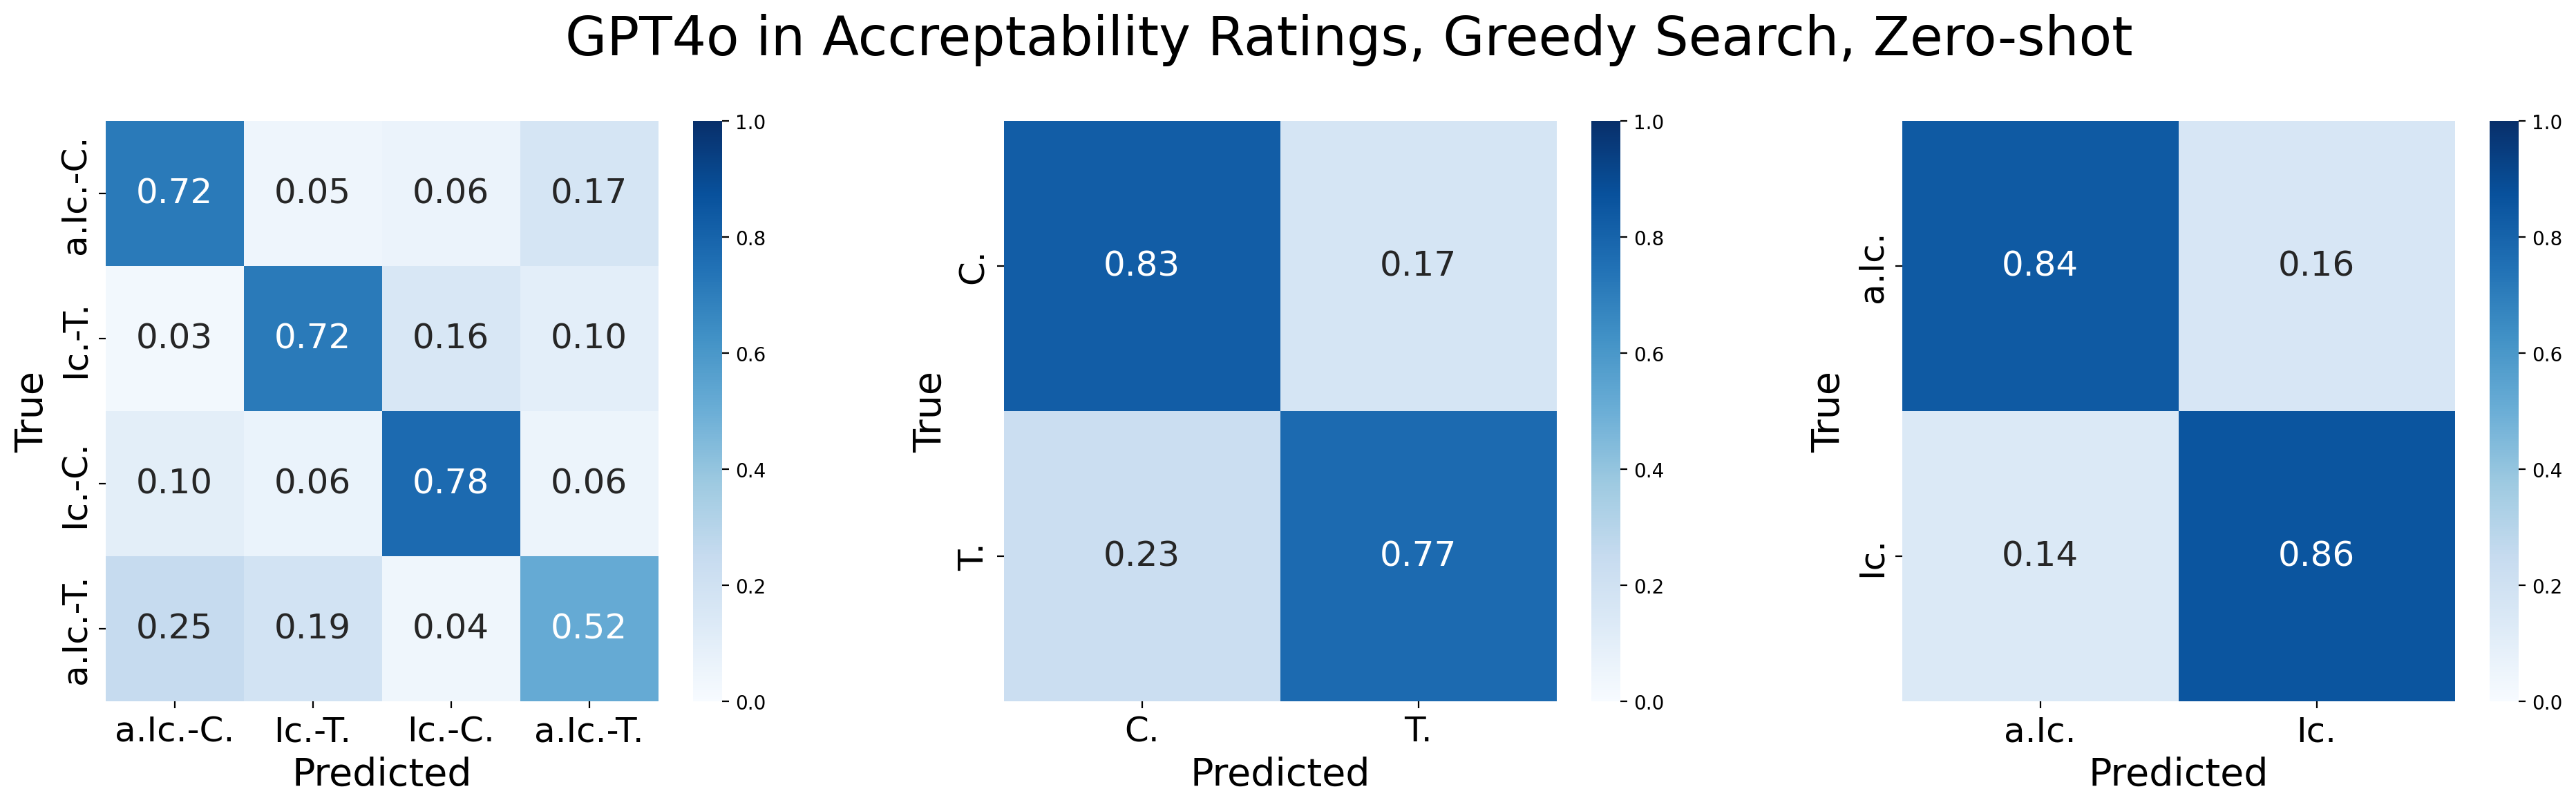

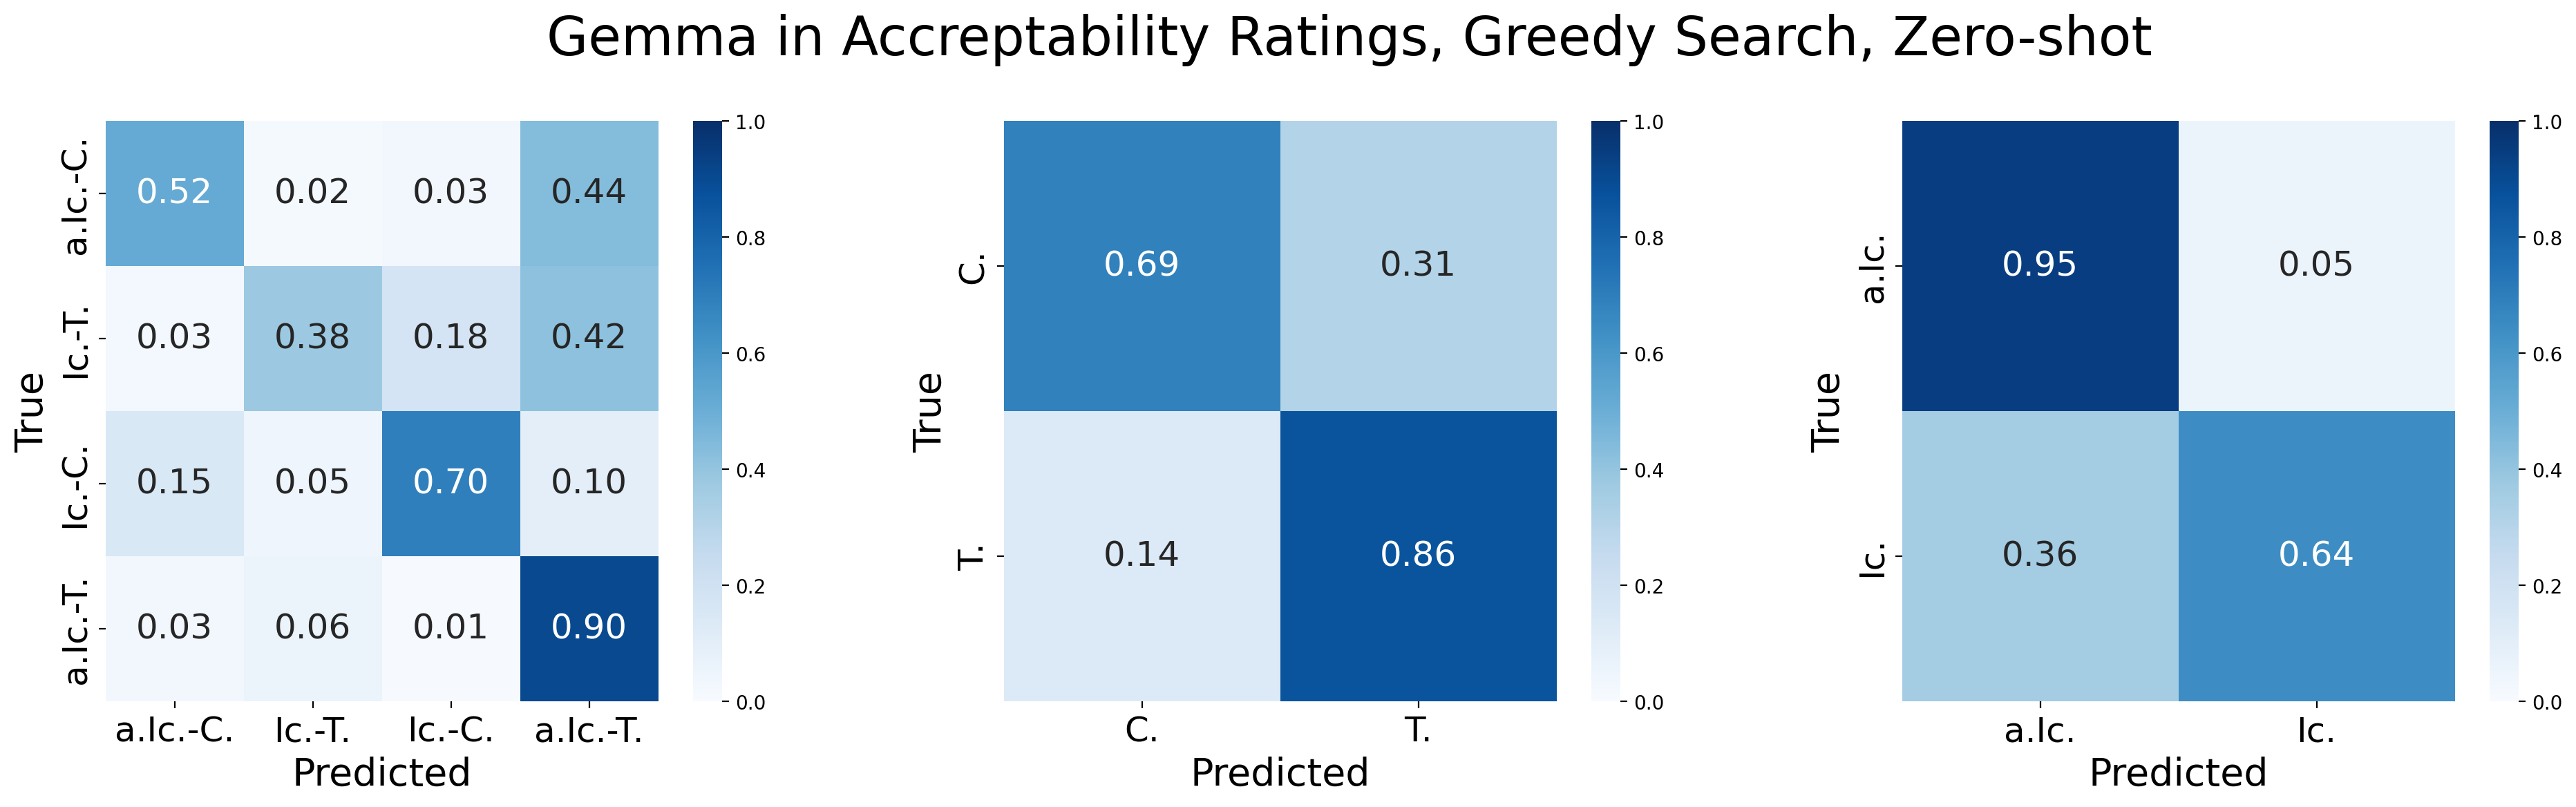

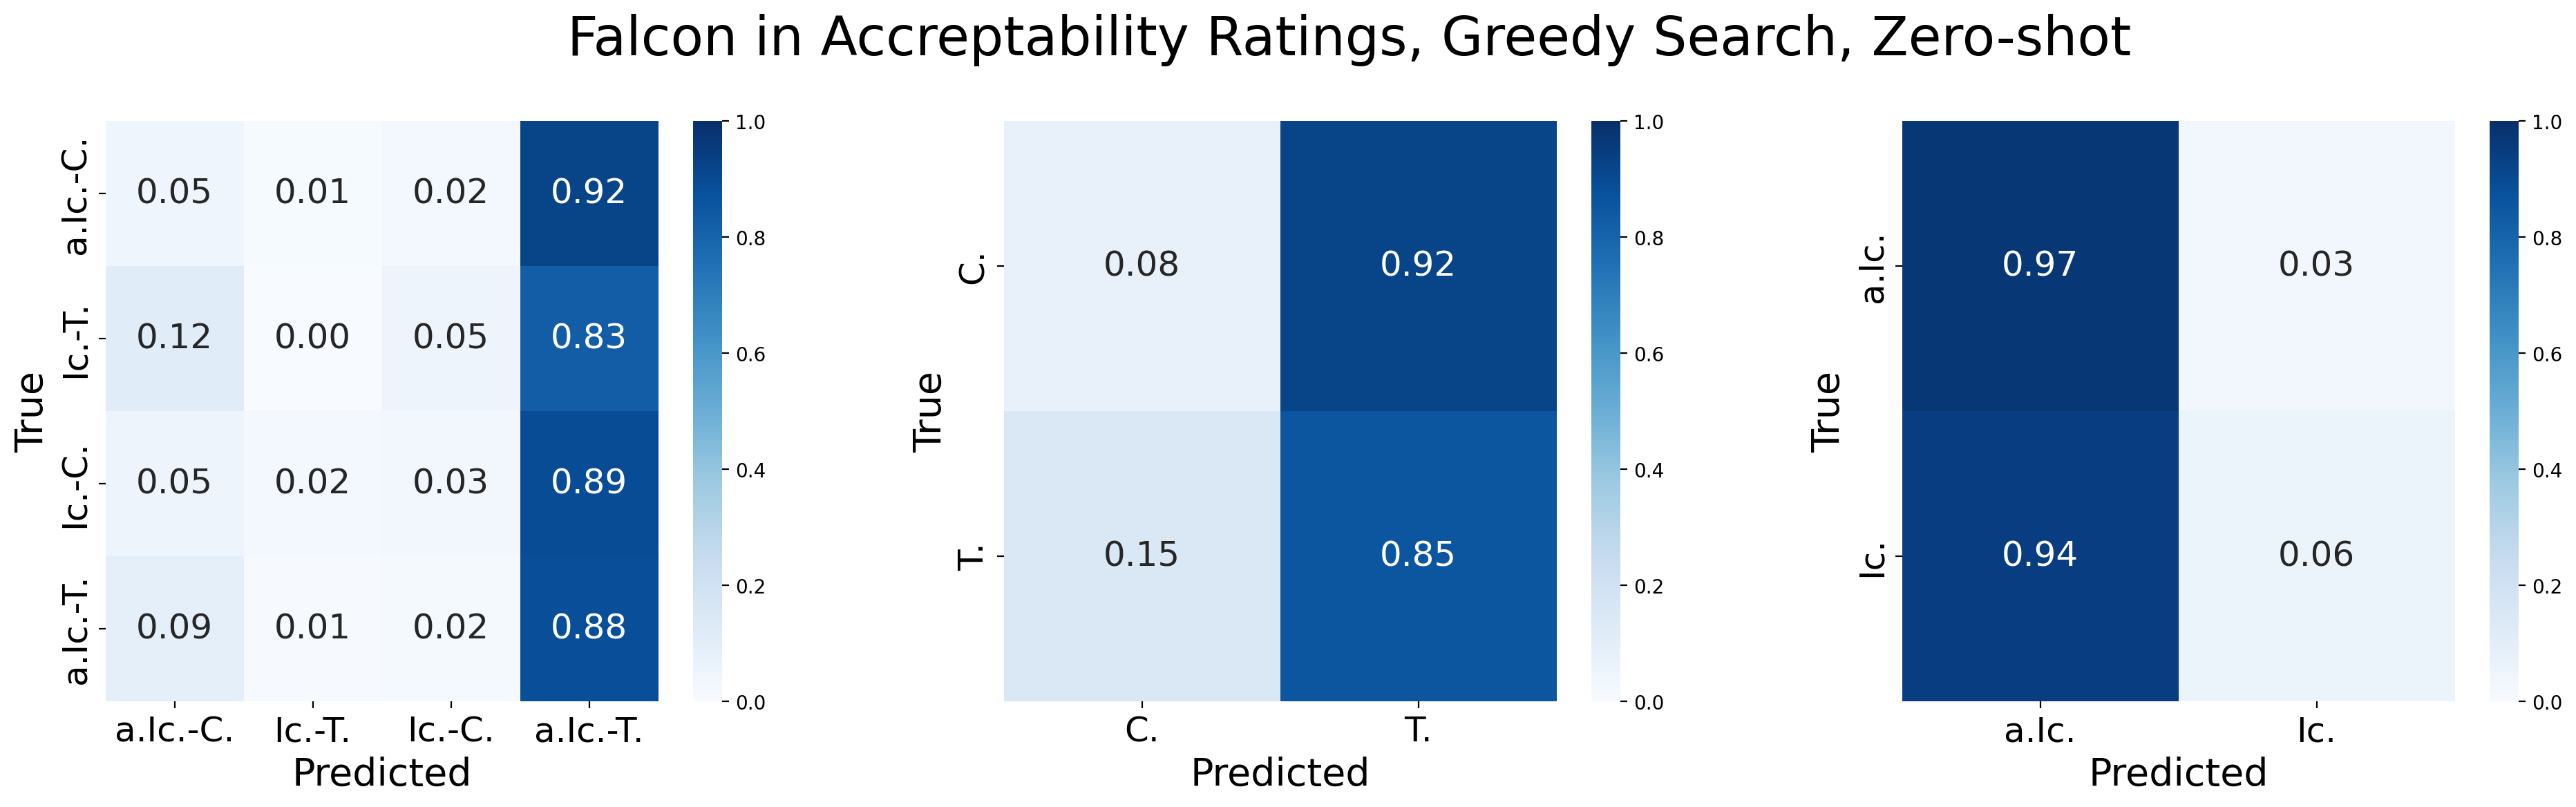

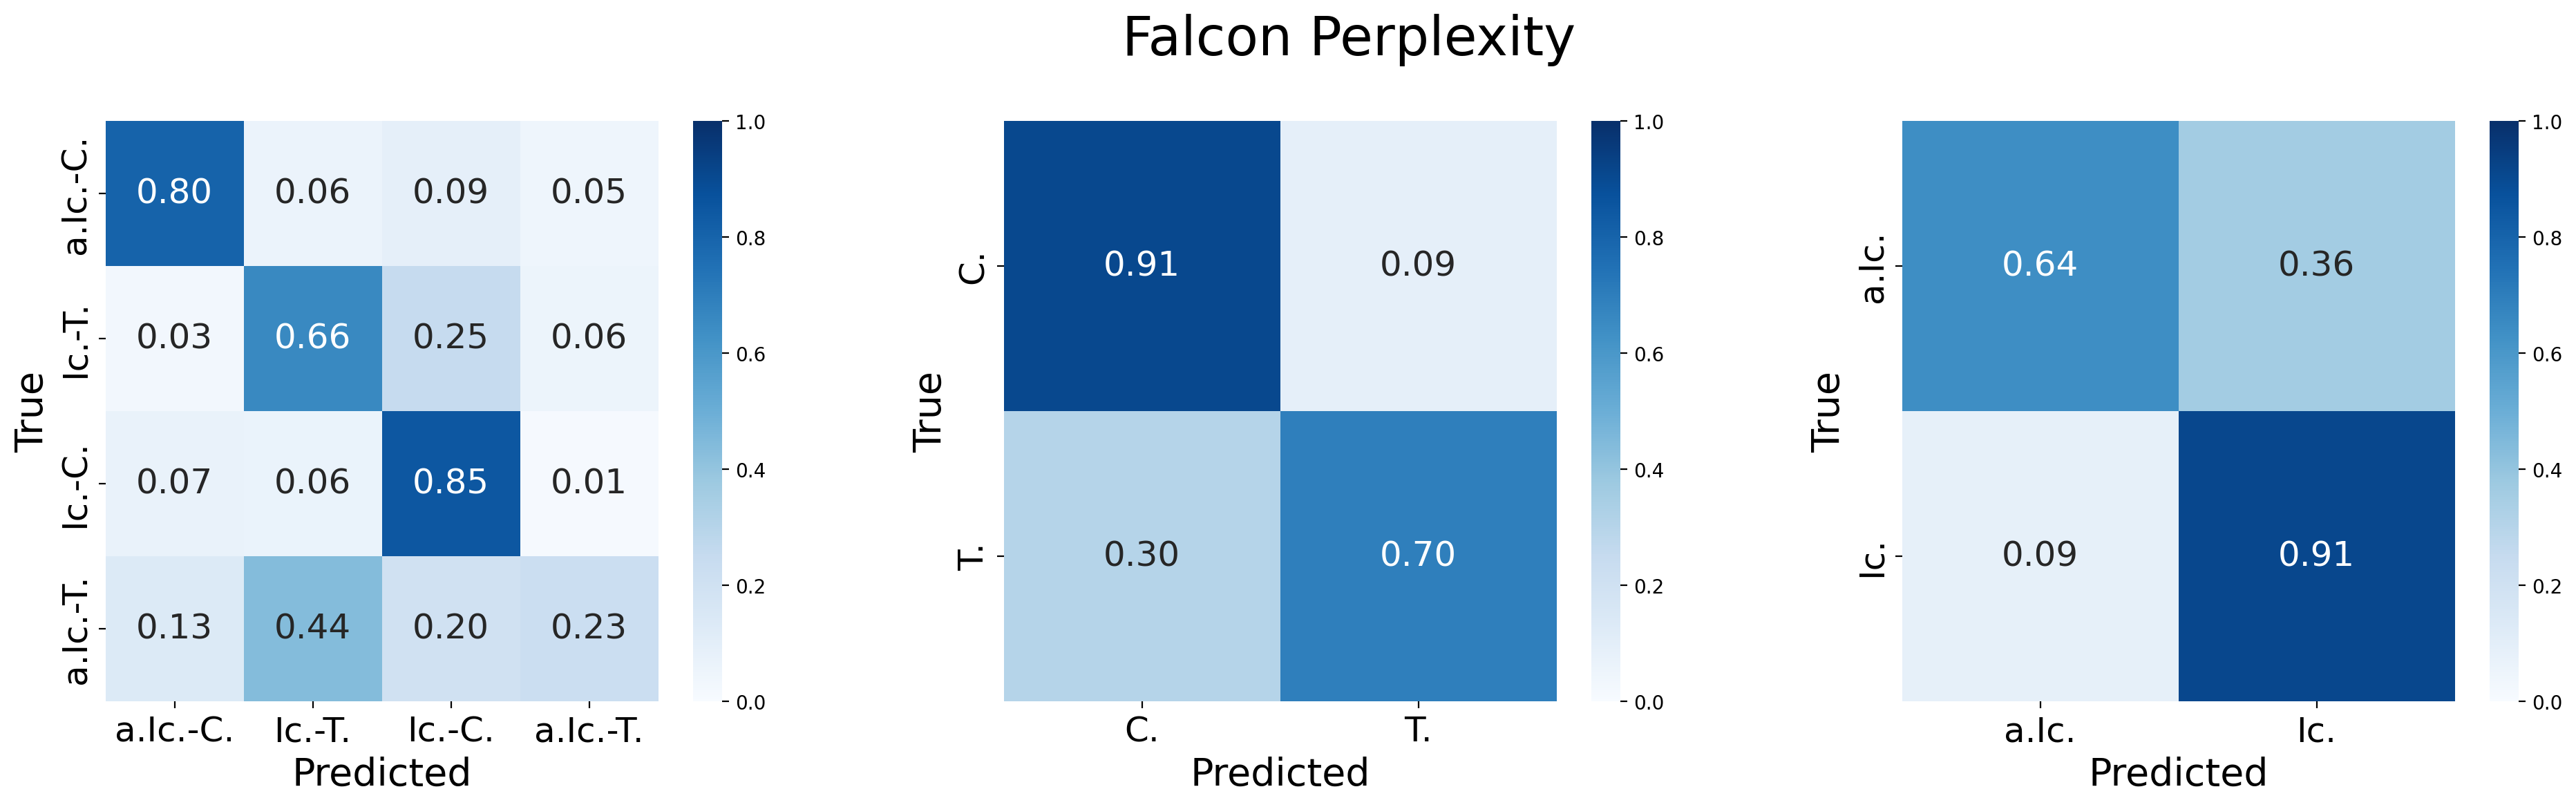

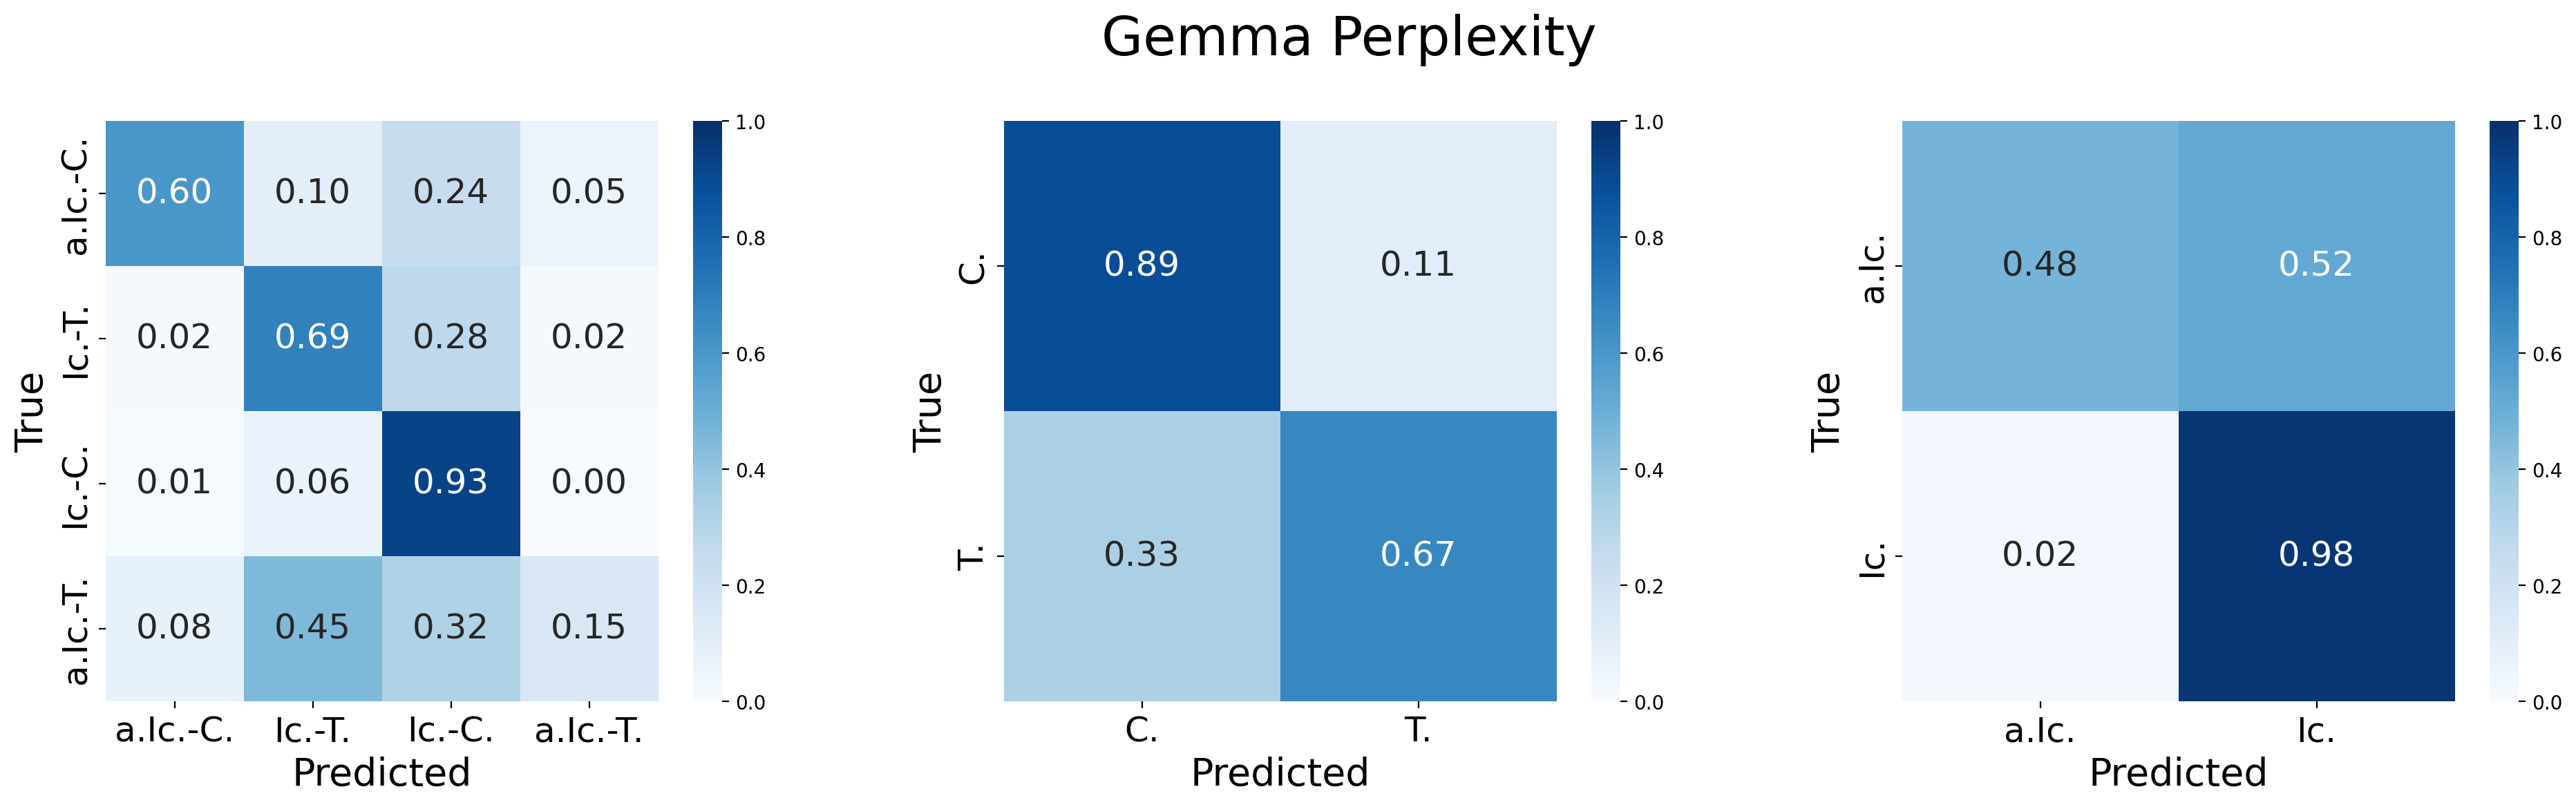

In [6]:
%matplotlib inline
%config InlineBackend.figure_format='retina'


_dir = "Outputs_revised"


for key, df in dfs_dict_rename.items():

    outname = key
    newdf = df
   
    cms = []
    tests = ["relation and direction", "relation", "direction"]
    all_labels = []

    
    labels = list(set(newdf['human_condition'].tolist() + newdf['predict_condition'].tolist()))
    all_labels.append(labels)

    # Create mapping from tuples to unique integers and back
    label_to_int = {label: idx for idx, label in enumerate(labels)}
    int_to_label = {idx: label for label, idx in label_to_int.items()}

    # Convert true and predicted labels to their integer representations
    newdf['human_condition_int'] = newdf['human_condition'].map(label_to_int)
    newdf['predict_condition_int'] = newdf['predict_condition'].map(label_to_int)

    # Generate confusion matrix
    cm = confusion_matrix(newdf['human_condition_int'], newdf['predict_condition_int'], labels=list(label_to_int.values()))
    cms.append(cm)

    # plot only on relation
    
    labels = list(set(newdf['relation_human'].tolist() + newdf['predict_relation'].tolist()))
    all_labels.append(labels)


    # Create mapping from tuples to unique integers and back
    label_to_int = {label: idx for idx, label in enumerate(labels)}
    int_to_label = {idx: label for label, idx in label_to_int.items()}

    # Convert true and predicted labels to their integer representations
    newdf['human_relation_int'] = newdf['relation_human'].map(label_to_int)
    newdf['predict_relation_int'] = newdf['predict_relation'].map(label_to_int)

    # Generate confusion matrix
    cm = confusion_matrix(newdf['human_relation_int'], newdf['predict_relation_int'], labels=list(label_to_int.values()))
    cms.append(cm)

    # plot only on direction
    labels = list(set(newdf['order_human'].tolist() + newdf['predict_direction'].tolist()))
    all_labels.append(labels)

    # Create mapping from tuples to unique integers and back
    label_to_int = {label: idx for idx, label in enumerate(labels)}
    int_to_label = {idx: label for label, idx in label_to_int.items()}

    # Convert true and predicted labels to their integer representations
    newdf['human_direction_int'] = newdf['order_human'].map(label_to_int)
    newdf['predict_direction_int'] = newdf['predict_direction'].map(label_to_int)

    # Generate confusion matrix
    cm = confusion_matrix(newdf['human_direction_int'], newdf['predict_direction_int'], labels=list(label_to_int.values()))
    cms.append(cm)

    fig, axes = plt.subplots(1, 3, figsize=(20, 6), sharey=False)  # Increase figure size
    plt.suptitle(outname, fontsize=28)

    # Adjust subplot spacing
    plt.subplots_adjust(wspace=0.3, left=0.05, right=0.95, top=0.85, bottom=0.15)  # Fine-tune spacing

    for i, (test, labels, cm) in enumerate(zip(tests, all_labels, cms)):
        cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

        sns.heatmap(cmn, annot=True, fmt='.2f', cmap='Blues',
                    xticklabels=labels, yticklabels=labels, ax=axes[i],
                    vmin=0, vmax=1, annot_kws={"size": 18})  # Slightly bigger annotation size

        axes[i].set_xlabel('Predicted', fontsize=20)  # Slightly bigger labels
        axes[i].set_ylabel('True', fontsize=20)

        axes[i].tick_params(axis='both', which='major', labelsize=18)  # Bigger tick labels

    # Show the figure
    plt.show()
